In [ ]:
# DSP 461: Final Project
# Carly Carroll

In [10]:
##### LOAD LIBRARIES #####

import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, classification_report
from sklearn.inspection import PartialDependenceDisplay
import os
from google.colab import files
import joblib

In [12]:
##### DATA UPLOADING AND PREPROCESSING #####

# manually upload affordability data
uploaded = files.upload()

#load in affordability data
affordability = pd.read_csv("affordability.csv")

# drop duplicates within the data
affordabilty = affordability.drop_duplicates(subset=['RegionName', 'StateName'])

Saving affordability.csv to affordability (3).csv


In [25]:
### feature engineering and scaling ###

# define regression features and target
regression_features = [
    "HousingCostAvg", "TotalLivingCost", "median_family_income",
    "TotalPop", "crime_rate_per_100000"
]
X_reg = affordability[regression_features]
y_reg = affordability["AffordabilityScore"]

# define classification features and target
classification_features = [
    "INflow", "OUTflow", "TotalPop", "HousingCostAvg", "median_family_income"
]
X_class = affordability[classification_features]
if "MigrationClass" not in affordability.columns:
    affordability["MigrationClass"] = pd.cut(
        affordability["NET in"], bins=[-float('inf'), -1, 1, float('inf')],
        labels=["Net Loss", "Neutral", "Net Gain"]
    )
y_class = affordability["MigrationClass"]

## scale features
scaler = StandardScaler()
X_reg_scaled = scaler.fit_transform(X_reg)
X_class_scaled = scaler.fit_transform(X_class)

## split the data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_scaled, y_reg, test_size=0.3, random_state=42
)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class_scaled, y_class, test_size=0.3, random_state=42
)

# separate scalers for affordability and migration
scaler_affordability = StandardScaler()
scaler_migration = StandardScaler()

# fit scalers on respective datasets
X_affordability = affordability[["HousingCostAvg", "TotalLivingCost", "median_family_income", "TotalPop", "crime_rate_per_100000"]]
X_migration = affordability[["INflow", "OUTflow", "TotalPop", "HousingCostAvg", "median_family_income"]]

scaler_affordability.fit(X_affordability)
scaler_migration.fit(X_migration)

StandardScaler()

In [26]:
### model training ###

# train regression model
regressor = RandomForestRegressor(random_state=42, n_estimators=100)
regressor.fit(X_train_reg, y_train_reg)

# train classification model
classifier = RandomForestClassifier(random_state=42, n_estimators=100)
classifier.fit(X_train_class, y_train_class)

RandomForestClassifier(random_state=42)

In [27]:
### prediction functions ###

# affordability prediction function
def predict_affordability(HousingCostAvg, TotalLivingCost, median_family_income, TotalPop, crime_rate_per_100000):
    features = pd.DataFrame(
        [[HousingCostAvg, TotalLivingCost, median_family_income, TotalPop, crime_rate_per_100000]],
        columns=["HousingCostAvg", "TotalLivingCost", "median_family_income", "TotalPop", "crime_rate_per_100000"]
    )
    scaled_features = scaler_affordability.transform(features)
    prediction = regressor.predict(scaled_features)
    return f"Predicted Affordability Score: {prediction[0]:.2f}"

# migration classification function
def classify_migration(INflow, OUTflow, TotalPop, HousingCostAvg, median_family_income):
    features = pd.DataFrame(
        [[INflow, OUTflow, TotalPop, HousingCostAvg, median_family_income]],
        columns=["INflow", "OUTflow", "TotalPop", "HousingCostAvg", "median_family_income"]
    )
    scaled_features = scaler_migration.transform(features)
    prediction = classifier.predict(scaled_features)
    return f"Predicted Migration Class: {prediction[0]}"

In [31]:
### gradio interfaces ###

# affordability prediction interface
def affordability_interface():
    affordability_output = predict_affordability(1200, 1500, 65000, 100000, 350)
    print(affordability_output)

# migration classification interface
def migration_interface():
    migration_output = classify_migration(5000, 4000, 100000, 1200, 65000)
    print(migration_output)

# feature importance visualization
def feature_importance_visualization():
    importance = regressor.feature_importances_
    features = regression_features
    plt.figure(figsize=(8, 6))
    sns.barplot(x=importance, y=features)
    plt.title("Feature Importance for Affordability Prediction")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

Predicted Affordability Score: 0.80
Predicted Migration Class: Net Gain


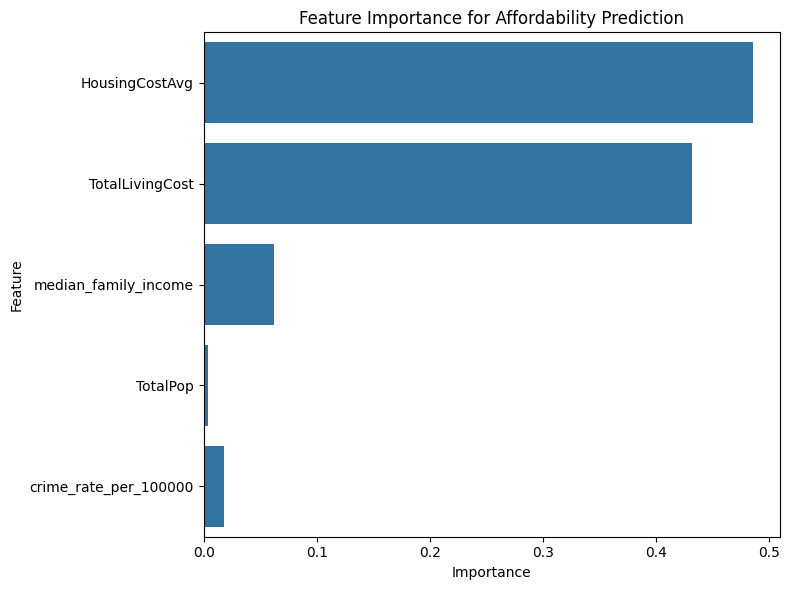

In [32]:
### run gradio script ###

# call necessary functions
affordability_interface()
migration_interface()
feature_importance_visualization()